# Group by: the bread and butter of analytics

Dans le notebook précédent, on a vu que les agrégations trouvent très vite leurs limites si elles ne sont pas faites au bon niveau.

Pour réduire le set sur lequel on va réaliser l'agrégation, on peut utiliser la clause groupby

Ca fonctionne de la manière suivante:

## Exemple ventes client

Imaginons qu'on ait une table de ventes avec le montant dépensé par chaque client pour chaque opération:

In [7]:
import pandas as pd
import duckdb

In [8]:
clients = ["Oussama", "Julie", "Chris", "Tom"]
ventes = [120, 49, 35, 23, 19, 5.99, 20, 18.77, 39, 10, 17, 12]

ventes = pd.DataFrame(ventes)
ventes.columns = ["montant"]
ventes["client"] = clients * 3
ventes

,montant,client
0,120.00,Oussama
1,49.00,Julie
2,35.00,Chris
3,23.00,Tom
4,19.00,Oussama
5,5.99,Julie
6,20.00,Chris
7,18.77,Tom
8,39.00,Oussama
9,10.00,Julie


On aimerait savoir qui est notre plus gros client, pour lui envoyer un cadeau.
<br />

Pour cela, il nous faut, pour chaque client, la somme de ses dépenses

Ce serait plus simple si on avait une table par client:

In [13]:
ventes_tom = duckdb.sql("SELECT * FROM ventes WHERE client='Tom'").df()
ventes_tom["montant"].sum()

53.769999999999996

On pourrait faire ça pour chaque _"sous table"_:

In [14]:
ventes_oussama = duckdb.sql("SELECT * FROM ventes WHERE client='Oussama'").df()
ventes_oussama["montant"].sum()

178.0

Et ensuite, il ne reste plus qu'à combiner les résultats !

<blockquote> C'est beaucoup de boulot ton truc, y'a pas une commande pour tout faire d'un coup ?! </blockquote>

Si, c'est exactement le but d'un group by

## La clause "Group by"

Derrière le rideau, Group By effectue un "Split-apply-combine"

(voir doc: https://pandas.pydata.org/docs/user_guide/groupby.html)

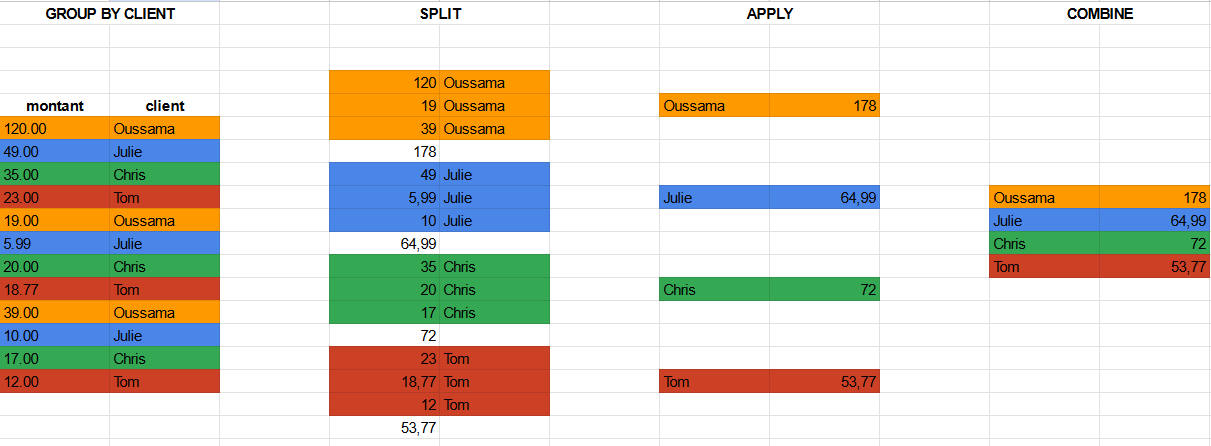

In [20]:
(
    ventes
    .groupby("client")
    ["montant"].sum()
)

client
Chris       72.00
Julie       64.99
Oussama    178.00
Tom         53.77
Name: montant, dtype: float64

In [21]:
query = """
SELECT client, SUM(montant)
FROM ventes
GROUP BY client
"""

duckdb.sql(query)

┌─────────┬────────────────────┐
│ client  │    sum(montant)    │
│ varchar │       double       │
├─────────┼────────────────────┤
│ Oussama │              178.0 │
│ Julie   │  64.99000000000001 │
│ Chris   │               72.0 │
│ Tom     │ 53.769999999999996 │
└─────────┴────────────────────┘

## Exercice ventes immo

In [24]:
import pandas as pd
import numpy as np

dates = [f"2023-08-{str(x).zfill(2)}" for x in range(7, 21)]

ventes_immo = pd.DataFrame([
    [0, "vieux_lille", 460000],
    [1, "vieux_lille", 430000],
    [2, "vieux_lille", 450000],
    [3, np.NaN, 470000],
    [4, "vieux_lille", 440000],
    [10, "gambetta", 336000],
    [11, np.NaN, 333000],
    [12, "gambetta", 335000],
    [13, "gambetta", 337000],
    [14, "gambetta", 334000],
    [20, "centre", 356000],
    [21, "centre", 353000],
    [22, np.NaN, 355000],
    [23, "centre", 357000],
    [24, "centre", 354000],
    [30, "wazemmes", 260000],
    [31, np.NaN, 230000],
    [32, "wazemmes", 250000],
    [33, "wazemmes", 270000],
    [34, "wazemmes", 240000],
]
)

ventes_immo.columns = ["flat_id", 
                       "neighborhood", 
                       "price"]

In [25]:
ventes_immo

,flat_id,neighborhood,price
0,0,vieux_lille,460000
1,1,vieux_lille,430000
2,2,vieux_lille,450000
3,3,NaN,470000
4,4,vieux_lille,440000
5,10,gambetta,336000
6,11,NaN,333000
7,12,gambetta,335000
8,13,gambetta,337000
9,14,gambetta,334000


---

In [32]:
%load solutions/1groupby_simple_python.py

neighborhood,centre,gambetta,vieux_lille,wazemmes
price,355000.0,335500.0,445000.0,255000.0


In [37]:
%load solutions/2groupby_simple_sql.py

┌──────────────┬─────────────┐
│ neighborhood │ mean(price) │
│   varchar    │   double    │
├──────────────┼─────────────┤
│ vieux_lille  │    445000.0 │
│ NULL         │    347000.0 │
│ gambetta     │    335500.0 │
│ centre       │    355000.0 │
│ wazemmes     │    255000.0 │
└──────────────┴─────────────┘

## Note: coalesce

Les valeurs NULL sont regroupées par SQL comme étant une catégorie à part entière. 

Essayez d'utiliser le mot clé "COALESCE" pour remplacer "NULL" par "inconnu"


In [40]:
query = """
SELECT COALESCE(neighborhood, 'inconnu'), MEAN(price) 
FROM ventes_immo
GROUP BY neighborhood
"""

duckdb.sql(query)


┌───────────────────────────────────┬─────────────┐
│ COALESCE(neighborhood, 'inconnu') │ mean(price) │
│              varchar              │   double    │
├───────────────────────────────────┼─────────────┤
│ vieux_lille                       │    445000.0 │
│ inconnu                           │    347000.0 │
│ gambetta                          │    335500.0 │
│ centre                            │    355000.0 │
│ wazemmes                          │    255000.0 │
└───────────────────────────────────┴─────────────┘

Dans le prochain notebook, on va continuer de s'exercer sur les Group By, et découvrir comment filtrer sur leurs résultats